In [ ]:
# Set working directory to parent directory for proper imports
# import os
# import sys

# # Get current directory
# current_dir = os.getcwd()
# print(f"Current directory: {current_dir}")

# # Change to parent directory
# parent_dir = os.path.dirname(current_dir)
# os.chdir(parent_dir)
# print(f"Changed to parent directory: {os.getcwd()}")

# # Add parent directory to path if needed
# if parent_dir not in sys.path:
#     sys.path.insert(0, parent_dir)
#     print(f"Added {parent_dir} to sys.path")

Current directory: c:\Users\bar21\Dropbox\My PC (LAPTOP-6NAJD2IQ)\Desktop\Gate\University\TAU\PhD\Writing\Drafts\Sampled networks
Changed to parent directory: c:\Users\bar21\Dropbox\My PC (LAPTOP-6NAJD2IQ)\Desktop\Gate\University\TAU\PhD\Writing\Drafts
Added c:\Users\bar21\Dropbox\My PC (LAPTOP-6NAJD2IQ)\Desktop\Gate\University\TAU\PhD\Writing\Drafts to sys.path


In [1]:
import os

N_CORES = 4
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={N_CORES}"


import jax.numpy as jnp
from jax import random, vmap
import jax
from jax.scipy.special import logit

from tqdm import tqdm
import numpy as np
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, leaves_list

import Simulations.data_gen as dg
# import data_gen as dg
from src.MWG_sampler import MWG_sampler, MWG_init
import src.utils as utils
from src.Models import cond_logpost_a_star, triu_star_grad_fn

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['savefig.facecolor'] = 'white'





In [2]:
# Global variables (as in mwg_simulation.py)

N = 500
TRIU_DIM = N * (N - 1) // 2

THETA = jnp.array([-2.5, 1])
GAMMA_BASELINE = jnp.array([logit(0.95), logit(0.05)])

GAMMA_REP = jnp.array([logit(0.8), 1.5, logit(0.2), 1.5])
GAMMA_X_NOISES = jnp.arange(2, 4 + 1e-6, 0.5)

GAMMA_B_NOISE_0 = GAMMA_BASELINE[0] - GAMMA_X_NOISES / 2
GAMMA_B_NOISE_1 = GAMMA_BASELINE[1] + GAMMA_X_NOISES / 2

ETA = jnp.array([-1, 3, -0.5, 2])
SIG_INV = 1.0
RHO = 0.5
PZ = 0.5


PARAM = {
    "theta": THETA,
    "eta": ETA,
    "rho": RHO,
    "sig_inv": SIG_INV,
}

# Take mid value of GAMMA_X_NOISES for illustration

cur_gamma = jnp.concatenate(
                [
                    jnp.array([GAMMA_B_NOISE_0[2]]),
                    jnp.array([GAMMA_B_NOISE_1[2]]),
                    jnp.array([GAMMA_X_NOISES[2]]),
                    GAMMA_REP,
                ]
            )

print(cur_gamma)



[ 1.4444387 -1.4444389  3.         1.3862945  1.5       -1.3862944
  1.5      ]


In [3]:
# rng_key = random.PRNGKey(1159)
rng_key = random.PRNGKey(0)

# generate data (not depedent on gamma)
rng_key, _ = random.split(rng_key)
fixed_data = dg.generate_fixed_data(rng_key, N, PARAM, PZ)

# true_vals for wasserstein distance
true_vals = {
    "eta": ETA,
    "rho": jnp.array([RHO]),
    "sig_inv": jnp.array([SIG_INV]),
    "triu_star": fixed_data["triu_star"],
}

print(f"mean true exposures: {jnp.mean(fixed_data['true_exposures']):.3f}")

# generate new interventions
rng_key, _ = random.split(rng_key)
new_interventions = dg.new_interventions_estimands(
    rng_key, N, fixed_data["x"], fixed_data["triu_star"], ETA
)

print(f"mean dynamic estimands: {jnp.mean(new_interventions.estimand_h):.3f}")
print(f"mean stochastic estimands: {jnp.mean(new_interventions.estimand_stoch):.3f}")

mean true exposures: 2.549
mean dynamic estimands: 4.123
mean stochastic estimands: 5.401


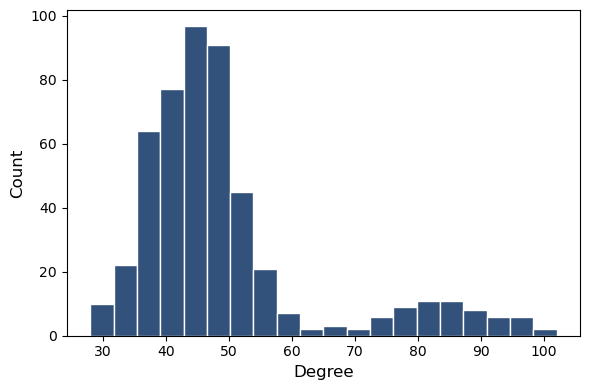

In [59]:
# plot true network degree distribution
matplotlib.rcParams['xtick.color'] = 'black'
matplotlib.rcParams['ytick.color'] = 'black'
matplotlib.rcParams['axes.labelcolor'] = 'black'
matplotlib.rcParams['axes.edgecolor'] = 'black'
matplotlib.rcParams['axes.titlesize'] = 'large'
matplotlib.rcParams['axes.labelsize'] = 'medium'


true_degs = jnp.sum(utils.Triu_to_mat(fixed_data["triu_star"]), axis=1)

plt.figure(figsize=(6, 4))
plt.hist(true_degs, bins=20, color="#32527b", edgecolor="white")

plt.xlabel("Degree", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.gca().set_facecolor("white")  # Ensure background is white

plt.tight_layout()



plt.savefig("Simulations/results/figs/degree_hist.png", 
            dpi=300,
            bbox_inches="tight")

plt.show()

In [4]:
rng_key = random.split(rng_key)[0]
# sample proxy networks with current gamma
proxy_nets = dg.generate_proxy_networks(
    # rng,
    rng_key,
    TRIU_DIM,
    fixed_data["triu_star"],
    cur_gamma,
    fixed_data["x_diff"],
    fixed_data["Z"],
)

data_sim = dg.data_for_sim(fixed_data, proxy_nets)


In [5]:
# --- MWG init params (single proxy) ---

rng_key = random.split(rng_key)[1]
mwg_init = MWG_init(
    rng_key=rng_key,
    data=data_sim,
    progress_bar=True,
).get_init_values()

# --- Sampling with MWG (single proxy) ---

rng_key = random.split(rng_key)[1]

mwg_sampler = MWG_sampler(
    rng_key=rng_key,
    data=data_sim,
    init_params=mwg_init,
    progress_bar=True,
)



Initializing parameters for MWG sampler...


100%|██████████| 20000/20000 [01:23<00:00, 238.83it/s, init loss: 115578.1875, avg. loss [19001-20000]: 54296.7632]


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

In [6]:
# post_mean_probs = jnp.mean(mwg_sampler.posterior_samples["triu_star"], axis=0)

# Save and read for later
# np_post_probs = np.asarray(post_mean_probs)
# np.savetxt("Simulations/results/post_triu_star_prob.txt", np_post_probs)
# 
post_mean_probs = np.loadtxt("Simulations/results/post_triu_star_prob.txt")
# post_mean_probs = np.loadtxt("results/post_triu_star_prob.txt")
# post_edges = jnp.where(post_mean_probs > 1/3, 1, 0)
# post_edges = jnp.where(post_mean_probs > .25, 1, 0)
post_edges = jnp.where(post_mean_probs > .5, 1, 0)


In [7]:
true_net = utils.Triu_to_mat(data_sim.triu_star)
obs_net = utils.Triu_to_mat(data_sim.triu_obs_rep)
post_mean = utils.Triu_to_mat(post_edges)
post_mean_prob = utils.Triu_to_mat(post_mean_probs)

In [25]:
# Order edges by hierarchical clustering for clearer visualization

true_net_np = np.array(true_net)  

distances = pdist(true_net_np, metric='euclidean') 
Z = linkage(distances, method='ward')            

node_order = leaves_list(Z)                     

#  Apply the ordering to rows and columns in all matrices 
node_order_jax = jnp.array(node_order)

true_ordered = true_net[node_order_jax][:, node_order_jax]
observed_ordered = obs_net[node_order_jax][:, node_order_jax]
posterior_ordered = post_mean[node_order_jax][:, node_order_jax]
posterior_ordered_prob = post_mean_prob[node_order_jax][:, node_order_jax]



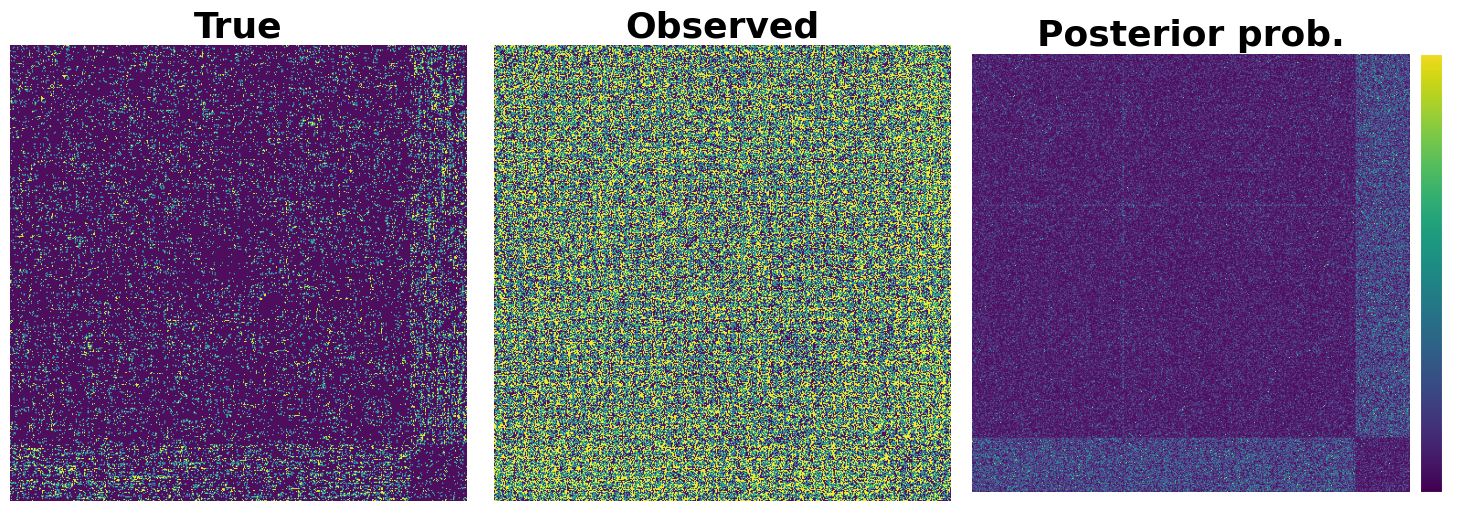

In [42]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plot the three reordered matrices side by side

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im1 = axes[0].imshow(true_ordered, alpha=.95, vmin=0, vmax=1)
axes[0].set_title("True", color="black", fontsize=26, fontweight="bold")
axes[0].axis("off")
# plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(observed_ordered, alpha=.95, vmin=0, vmax=1)
axes[1].set_title("Observed", color="black", fontsize=26, fontweight="bold")
axes[1].axis("off")
# plt.colorbar(im2, ax=axes[1])

# im3 = axes[2].imshow(posterior_ordered, alpha=.95)
# axes[2].set_title("Posterior (Bayes rule)", color="black",  fontsize=26, fontweight="bold")
# axes[2].axis("off")

im3 = axes[2].imshow(posterior_ordered_prob, alpha=.95, vmin=0, vmax=1)
axes[2].set_title("Posterior prob.", color="black",  fontsize=26, fontweight="bold")
axes[2].axis("off")
# plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)


divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.1)

# Draw the colorbar on that newly created axis
cbar = plt.colorbar(im3, cax=cax)
# cbar = plt.colorbar(im3, ax=axes[2])
# cbar.set_label('Edge value')

plt.tight_layout()
# plt.savefig("Simulations/results/figs/network_heatmap.png", 
#             dpi=300,
#             bbox_inches="tight")

plt.show()


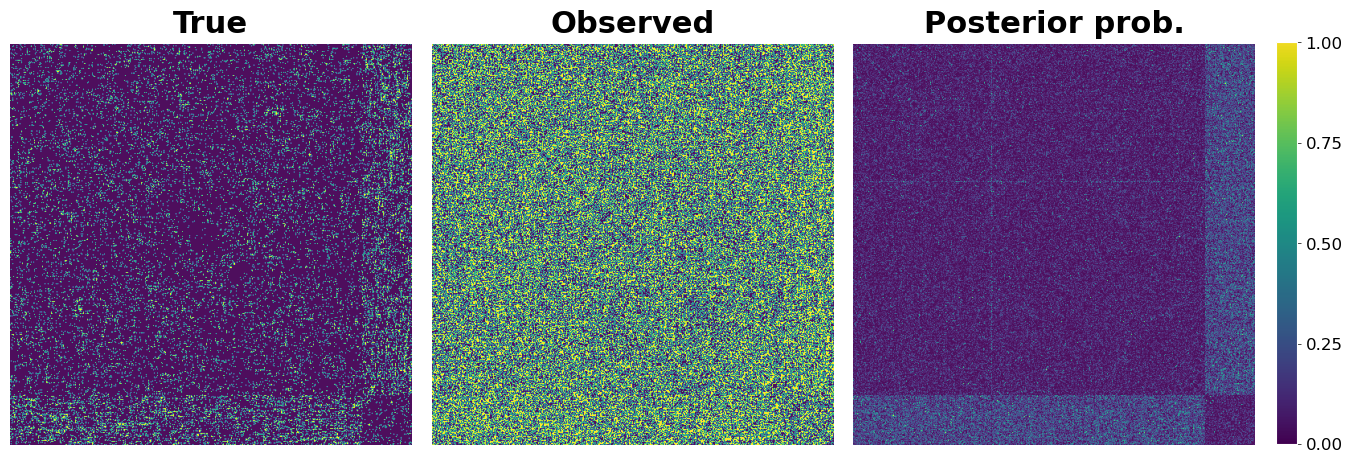

In [65]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# 1 row × 3 cols, no special width ratios needed
fig, axes = plt.subplots(1, 3, figsize=(15,5))

# Plot each heatmap with vmin/vmax=0/1 and a title
for ax, data, title in zip(axes,
                           [true_ordered, observed_ordered, posterior_ordered_prob],
                           ["True", "Observed", "Posterior prob."]):
    im = ax.imshow(data, vmin=0, vmax=1, cmap="viridis", alpha=.95)
    ax.set_title(title, fontsize=22, fontweight="bold", pad=8, color="black")
    ax.axis("off")

# Create an inset axes on the right side of the third plot,
# sized to 5% of its width and 100% of its height
cax = inset_axes(axes[2],
                 width="5%",    # 5% of the axes width
                 height="100%", # 100% of the axes height
                 loc="lower left",
                 bbox_to_anchor=(1.05, 0, 1, 1),
                 bbox_transform=axes[2].transAxes,
                 borderpad=0.1)

# Draw the colorbar in that inset, with ticks from 0 to 1
cbar = fig.colorbar(im, cax=cax, ticks=[0, 0.25, 0.5, 0.75, 1])
# cbar.set_label("Edge probability", fontsize=14, labelpad=10, color="black")
cbar.ax.tick_params(labelsize=12, length=3, width=.5, labelcolor="black", color="black")

# Tweak the outer margins so titles never get clipped
plt.subplots_adjust(left=0.05, right=0.88, top=0.88, bottom=0.05, wspace=0.05)

plt.savefig("Simulations/results/figs/network_heatmap_prob.png", 
            dpi=300,
            bbox_inches="tight")

plt.show()

In [ ]:
# --- Locally informed proposal ---
# test how well gradients approximate the true differences

params = utils.ParamTuple(
    theta=THETA,
    gamma=cur_gamma,
    eta=ETA,
    rho=RHO,
    sig_inv=SIG_INV,
)

_, grads = triu_star_grad_fn(data_sim.triu_obs_rep, data_sim, params)
score_grad = -(2*data_sim.triu_obs_rep-1)*grads/2

print(score_grad.shape)

(124750,)


In [ ]:
# Compute manual differences of log-posterior of A* for each edge flip

@jax.jit
def flip_val(x):
    return jnp.where(x == 0.0, 1.0, 0.0)

@jax.jit
def single_flip_logpost(i, triu, data, param):
    flipped = triu.at[i].set(flip_val(triu[i]))
    return cond_logpost_a_star(flipped, data, param)


score_logdensity = jnp.zeros(TRIU_DIM) 
for i in tqdm(range(TRIU_DIM)):
    score_logdensity = score_logdensity.at[i].set(
        single_flip_logpost(i, data_sim.triu_obs_rep, data_sim, params)
        )

baseline = cond_logpost_a_star(data_sim.triu_obs_rep, data_sim, params)
score_diffs = score_logdensity - baseline



100%|██████████| 124750/124750 [49:36<00:00, 41.91it/s] 


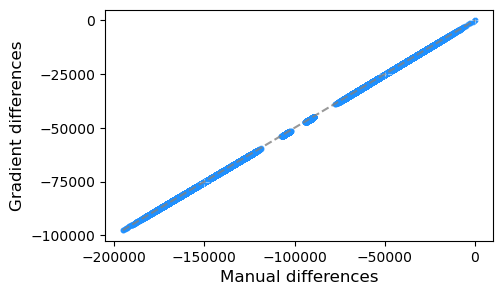

Pearson's correlation: 1.000


In [176]:
# plt.scatter(score_diffs[:3000], score_grad[:3000])
# plt.scatter(jax.nn.log_softmax(score_diffs[:3000]), jax.nn.log_softmax(score_grad[:3000]))

diff_log_softmax = jax.nn.log_softmax(score_diffs)
grad_log_softmax = jax.nn.log_softmax(score_grad)

plt.figure(figsize=(5, 3))  # Adjust figure size for better clarity
plt.scatter(
    diff_log_softmax, 
    grad_log_softmax, 
    s=10,  # Reduce point size for better visualization
    color='dodgerblue',  # Choose a color that contrasts well
    alpha=0.7  # Slight transparency for overlapping points
)

min_val = min(diff_log_softmax), min(grad_log_softmax)
max_val = max(diff_log_softmax), max(grad_log_softmax)
plt.plot([min_val[0], max_val[0]], [min_val[1], max_val[1]], linestyle="--", color="gray", alpha=0.8)

plt.xlabel("Manual differences", fontsize=12)
plt.ylabel("Gradient differences", fontsize=12)

plt.xticks(np.linspace(-2e5, 0, num=5))  # Adjust number of x-axis ticks
plt.yticks(np.linspace(-1e5, 0, num=5))  # Adjust number of y-axis ticks

plt.grid(True, linestyle="--", alpha=0.5)  # Add a subtle grid for readability
plt.gca().set_facecolor("white")  # Ensure background is white


plt.savefig("Simulations/results/figs/diff_vs_gradient_scatter.png", 
            dpi=300,
            bbox_inches="tight")

plt.show()


print(f"Pearson's correlation: {np.corrcoef(score_diffs, score_grad)[0, 1]:.3f}")
